# Stable Diffusion Deep Dive

Stable Diffusion is a powerful text-to-image model. There are various websites and tools to make using it as easy as possible. It is also [integrated into the Huggingface diffusers library](https://huggingface.co/blog/stable_diffusion) where generating images can be as simple as:
```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]

```

In this notebook we're going to dig into the code behind these easy-to-use interfaces, to see what is going on under the hood. We'll begin by re-creating the functionality above as a scary chunk of code, and then one by one we'll inspect the different components and figure out what they do. By the end of this notebook that same sampling loop should feel like something you can tweak and modify as you like. 

## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [1]:
!pip install -q --upgrade transformers diffusers ftfy accelerate xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.4 MB/s eta 0:00:00


In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
# if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from PIL import Image
from diffusers import StableUnCLIPImg2ImgPipeline, ImagePipelineOutput
from diffusers.image_processor import VaeImageProcessor
from diffusers.utils import randn_tensor, PIL_INTERPOLATION
from diffusers import LMSDiscreteScheduler, EulerDiscreteScheduler

In [4]:
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, variation="fp16"
)
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
pipe = pipe.to(device)

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


In [5]:
pipe.components.keys()

dict_keys(['feature_extractor', 'image_encoder', 'image_normalizer', 'image_noising_scheduler', 'tokenizer', 'text_encoder', 'unet', 'scheduler', 'vae'])

In [6]:
vae = pipe.vae
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet
scheduler = pipe.scheduler
# scheduler = EulerDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

feature_extractor = pipe.feature_extractor
image_encoder = pipe.image_encoder
image_normalizer = pipe.image_normalizer
image_noising_scheduler = pipe.image_noising_scheduler

In [7]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    dtype = next(vae.parameters()).dtype
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device, dtype=dtype)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

## Loop starting from noised version of input (AKA image2image)

Let's see what happens when we use our image as a starting point, adding some noise and then doing the final few denoising steps in the loop with a new prompt.

We'll use a similar loop to the first demo, but we'll skip the first `start_step` steps.

To noise our image we'll use code like that shown above, using the scheduler to noise it to a level equivalent to step 10 (`start_step`).

In [8]:
# Download a demo Image
# !curl --output content.jpg 'https://datepsychology.com/wp-content/uploads/2022/09/gigachad.jpg'
!curl --output content.jpg 'https://raw.githubusercontent.com/drixe18/diff_remix/main/assets/gigachad.jpg'
# !curl --output content.jpg 'https://imgflip.com/s/meme/One-Does-Not-Simply.jpg'
# !curl --output content.jpg 'https://raw.githubusercontent.com/drixe18/diff_remix/main/assets/boromir.jpg'

# !curl --output style.jpg 'https://i.iplsc.com/-/000C3LVW0CPJNM5U-C129.jpg'
!curl --output style.jpg 'https://raw.githubusercontent.com/drixe18/diff_remix/main/assets/shrek.jpg'
# !curl --output style.jpg 'https://i.kym-cdn.com/entries/icons/mobile/000/031/003/cover3.jpg'
# !curl --output style.jpg 'https://raw.githubusercontent.com/drixe18/diff_remix/main/assets/mike.jpg'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31589  100 31589    0     0   152k      0 --:--:-- --:--:-- --:--:--  152k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44362  100 44362    0     0   212k      0 --:--:-- --:--:-- --:--:--  212k


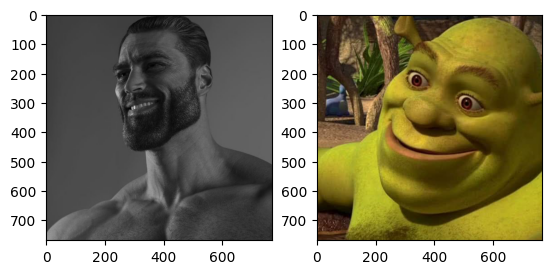

In [9]:
# Load the image with PIL

def open_image(url, size=768):
    image = Image.open(url).convert("RGB")
    w, h = image.size
    if h < w:
        h, w = size, size * w // h
    else:
        h, w = size * h // w, size

    image = image.resize((w, h))
    box = ((w - size) // 2, (h - size) // 2, (w + size) // 2, (h + size) // 2)
    return image.crop(box)

content_image = open_image('content.jpg')
style_image = open_image('style.jpg')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_image)
axs[1].imshow(style_image)

In [10]:
# Encode to the latent space
content_encoded = pil_to_latent(content_image)
style_encoded = pil_to_latent(style_image)
content_encoded.shape

torch.Size([1, 4, 96, 96])

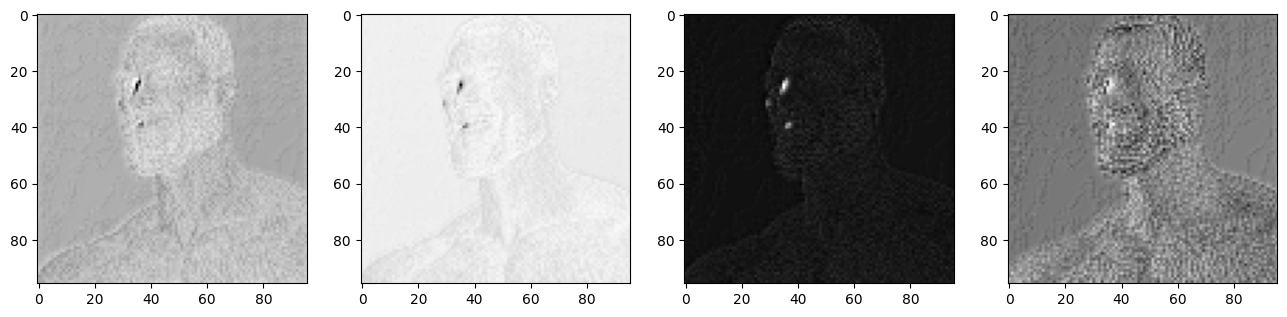

In [11]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(content_encoded[0][c].cpu(), cmap='Greys')

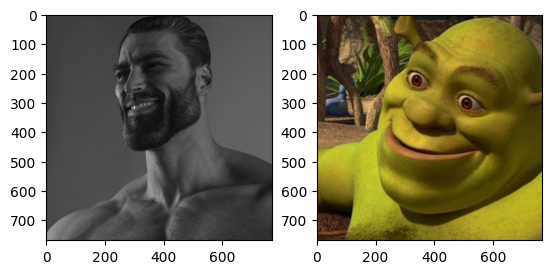

In [12]:
# Decode this latent representation back into an image
content_decoded = latents_to_pil(content_encoded)[0]
style_decoded = latents_to_pil(style_encoded)[0]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_decoded)
axs[1].imshow(style_decoded)

In [13]:
# from diffusers.models.embeddings import get_timestep_embedding


# def embed_image2(image):
#     dtype = next(image_encoder.parameters()).dtype
#     noise_level = 0

#     if not isinstance(image, torch.Tensor):
#         image = feature_extractor(images=image, return_tensors="pt").pixel_values

#     image = image.to(device=device, dtype=dtype)
#     image_embeds = image_encoder(image).image_embeds

#     noise = randn_tensor(image_embeds.shape, device=device, dtype=dtype)
#     noise_level = torch.tensor([noise_level] * image_embeds.shape[0], device=image_embeds.device)
#     image_embeds = image_normalizer.scale(image_embeds)
#     image_embeds = image_noising_scheduler.add_noise(image_embeds, timesteps=noise_level, noise=noise)
#     image_embeds = image_normalizer.unscale(image_embeds)
    
    
#     noise_level = get_timestep_embedding(
#         timesteps=noise_level, embedding_dim=image_embeds.shape[-1], flip_sin_to_cos=True, downscale_freq_shift=0
#     )

#     noise_level = noise_level.to(image_embeds.dtype)
#     image_embeds = torch.cat((image_embeds, noise_level), 1)

#     # duplicate image embeddings for each generation per prompt, using mps friendly method
#     image_embeds = image_embeds.unsqueeze(1)
#     bs_embed, seq_len, _ = image_embeds.shape
#     image_embeds = image_embeds.repeat(1, 1, 1)
#     image_embeds = image_embeds.view(bs_embed * 1, seq_len, -1)
#     image_embeds = image_embeds.squeeze(1)


#     negative_prompt_embeds = torch.zeros_like(image_embeds)

#     # For classifier free guidance, we need to do two forward passes.
#     # Here we concatenate the unconditional and text embeddings into a single batch
#     # to avoid doing two forward passes
#     image_embeds = torch.cat([negative_prompt_embeds, image_embeds])
#     return image_embeds

# content_emb = embed_image2(content_image)
# style_emb = embed_image2(style_image)

# alpha = .45
# style_emb = alpha * content_emb + (1 - alpha) * style_emb

# # alpha = 0.75
# # style_emb = slerp(alpha, content_emb, style_emb)

# content_emb.shape

In [14]:
from diffusers.models.embeddings import get_timestep_embedding

def slerp(val, low, high):
        low_norm = low/torch.norm(low, dim=1, keepdim=True)
        high_norm = high/torch.norm(high, dim=1, keepdim=True)
        omega = torch.acos((low_norm*high_norm).sum(1))
        so = torch.sin(omega)
        res = (torch.sin((1.0-val)*omega)/so).unsqueeze(1) * \
            low + (torch.sin(val*omega)/so).unsqueeze(1) * high
        return res


def prep_embeds(emb, noise_level):
    dtype = next(image_encoder.parameters()).dtype
    noise = randn_tensor(emb.shape, device=device, dtype=dtype)
    noise_level = torch.tensor([noise_level] * emb.shape[0], device=emb.device)
    emb = image_normalizer.scale(emb)
    emb = image_noising_scheduler.add_noise(emb, timesteps=noise_level, noise=noise)
    emb = image_normalizer.unscale(emb)
    
    noise_level = get_timestep_embedding(
        timesteps=noise_level, embedding_dim=emb.shape[-1], flip_sin_to_cos=True, downscale_freq_shift=0
    )

    noise_level = noise_level.to(emb.dtype)
    emb = torch.cat((emb, noise_level), 1)

    # duplicate image embeddings for each generation per prompt, using mps friendly method
    emb = emb.unsqueeze(1)
    bs_embed, seq_len, _ = emb.shape
    emb = emb.repeat(1, 1, 1)
    emb = emb.view(bs_embed * 1, seq_len, -1)
    emb = emb.squeeze(1)

    return emb


def cat_embeds(emb1, emb2):
    dtype = next(image_encoder.parameters()).dtype
    noise = randn_tensor(emb1.shape, device=device, dtype=dtype)
    noise_level = torch.tensor([0] * emb1.shape[0], device=emb1.device)
    emb1 = image_normalizer.scale(emb1)
    emb1 = image_noising_scheduler.add_noise(emb1, timesteps=noise_level, noise=noise)
    emb1 = image_normalizer.unscale(emb1)

    emb2 = image_normalizer.scale(emb2)
    emb2 = image_noising_scheduler.add_noise(emb2, timesteps=noise_level, noise=noise)
    emb2 = image_normalizer.unscale(emb2)

    emb = torch.cat((emb1, emb2), 1)

    # duplicate image embeddings for each generation per prompt, using mps friendly method
    emb = emb.unsqueeze(1)
    bs_embed, seq_len, _ = emb.shape
    emb = emb.repeat(1, 1, 1)
    emb = emb.view(bs_embed * 1, seq_len, -1)
    emb = emb.squeeze(1)

    return emb


def topk(emb, k=128, abs_vals=True, largest=True):
    topk = torch.topk(torch.abs(emb), k) if abs_vals else torch.topk(emb, k, largest=largest)
    topk_vals = torch.index_select(emb, 1, topk.indices.squeeze())
    return torch.zeros_like(emb).scatter(1, topk.indices, topk_vals)


def max_abs(x, y):
    maxs = torch.max(torch.abs(x), torch.abs(y))
    x_signs = (maxs == torch.abs(x)) * torch.sign(x)
    y_signs = (maxs == torch.abs(y)) * torch.sign(y)
    final_signs = x_signs.int() | y_signs.int()
    return maxs * final_signs


def embed_image3(image1, image2):
    dtype = next(image_encoder.parameters()).dtype
    noise_level = 0

    if not isinstance(image1, torch.Tensor):
        image1 = feature_extractor(images=image1, return_tensors="pt").pixel_values

    if not isinstance(image2, torch.Tensor):
        image2 = feature_extractor(images=image2, return_tensors="pt").pixel_values

    image1 = image1.to(device=device, dtype=dtype)
    image1_embeds = image_encoder(image1).image_embeds

    image2 = image2.to(device=device, dtype=dtype)
    image2_embeds = image_encoder(image2).image_embeds
    

    # image1_topk = topk(image1_embeds, 128)
    # image2_topk = topk(image2_embeds, 512)
    # combo_pos = max_abs(image1_topk, image2_topk)
    # combo_pos = torch.max(image1_pos, image2_pos)

    combo_pos = slerp(0.5, image1_embeds, image2_embeds)
    # combo_pos = image1_pos + image2_pos
    # combo_pos = torch.where(torch.abs(image2_pos) > 0, image2_pos, image1_pos)
    
    # image1_botk = topk(image1_embeds, 128, largest=False)
    # image2_botk = topk(image2_embeds, 128, largest=False)

    # combo_neg = max_abs(image1_botk, image2_botk)
    # combo_neg = torch.min(image1_neg, image2_neg)
    # combo_neg = slerp(0.5, image1_neg, image2_neg)
    # combo_neg = image1_neg + image2_neg
    # combo_neg = torch.where(torch.abs(image2_neg) > 0, image2_neg, image1_neg)

    # image_embeds = slerp(alpha, image1_embeds, image2_embeds-image1_embeds)
    # image_embeds = image_embeds - image2_embeds
    # image_embeds = alpha * image2_embeds + (1 - alpha) * image1_embeds
    # image_embeds = torch.lerp(image1_embeds, image2_embeds, alpha)
    image_embeds = prep_embeds(combo_pos, 0)

    # negative_prompt_embeds = prep_embeds(combo_neg, 0)
    negative_prompt_embeds = torch.zeros_like(image_embeds)

    image_embeds = torch.cat([negative_prompt_embeds, image_embeds])
    return image_embeds


style_embs = embed_image3(content_image, style_image)
style_embs.shape

torch.Size([2, 2048])

latents torch.Size([1, 4, 96, 96]), torch.float16
latents torch.Size([2, 77, 1024]), torch.float16


0it [00:00, ?it/s]

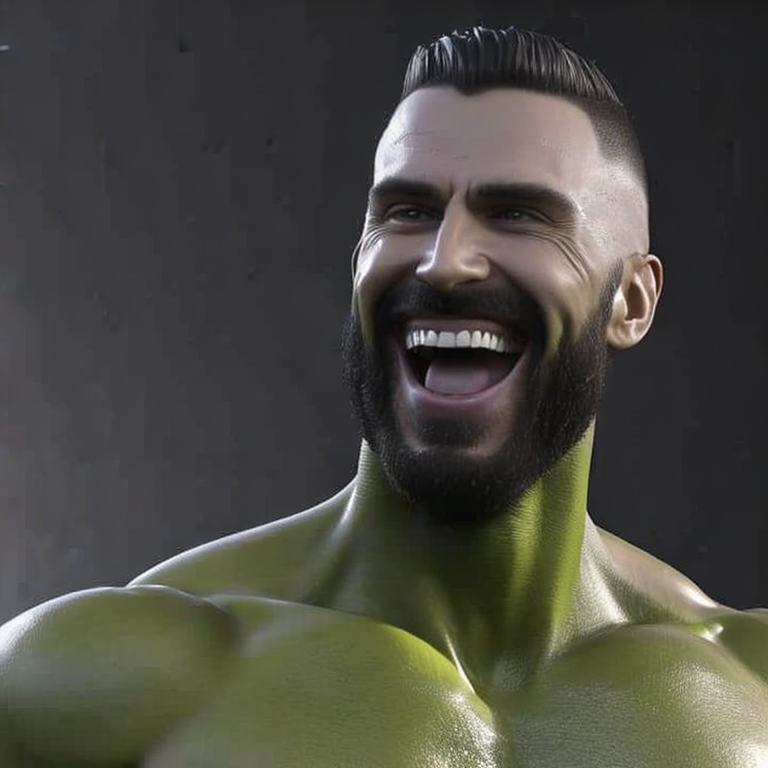

In [16]:
# Settings (same as before except for the new prompt)
# prompt = ["award winning, detailed, high quality, ultra hd"]
# prompt = ["cinematic lighting, digital painting, hyperrealistic, fantasy, stunning art, artstation, highly detailed, sharp focus"]
# prompt = ["digital painting, fantasy, artstation, highly detailed, sharp focus"]
prompt = ["character, 3d style, 8k, beautiful, digital painting, artstation, highly detailed, sharp focus"]
# prompt = [""]
neg_prompt = ["repulsive, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, bad anatomy, watermark, signature, cut off, low contrast, underexposed, overexposed, bad art, beginner, amateur, distorted face"]
# neg_prompt = ["ugly, disfigured, deformed"]
height = 768                        # default height of Stable Diffusion
width = 768                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
# blue_loss_scale = 2000


# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

uncond_input = text_input = tokenizer(neg_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


# Prep Scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 0
# start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(content_encoded)
alpha = 1.
encoded = alpha * content_encoded + (1 - alpha) * style_encoded
# latents = scheduler.add_noise(style_encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
# latents = scheduler.add_noise(content_encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device)

# # Prep latents
# start_step = 0
# dtype = next(unet.parameters()).dtype
# latents = torch.randn(
#   (batch_size, unet.in_channels, height // 8, width // 8),
#   generator=generator,
# )
# latents = latents.to(torch_device, dtype=dtype)
# latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

print(f'latents {latents.shape}, {latents.dtype}')
print(f'latents {text_embeddings.shape}, {text_embeddings.dtype}')
# print(f'latents {style_emb.shape}, {style_emb.dtype}')

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        # sigma = scheduler.sigmas[i]

        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            # noise_pred = unet(latent_model_input, t, class_labels=image_embeddings, encoder_hidden_states=text_embeddings)["sample"]
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings,
                class_labels=style_embs,
            ).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]